

```
Nama : Bagas Rizky Ramadhan
```


```
Email : bagasramadhan@apps.ipb.ac.id
```


```
Proyek Analisis Sentimen Kelas Belajar Pengembangan Machine Learning Dicoding
```






###**Import Library**###

In [ ]:
# Import libraries
import re
import string
from collections import Counter

import numpy as np
import pandas as pd

from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer


In [ ]:
pip install imbalanced-learn

###**Dataset**###

In [ ]:
# Memuat dataset
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Proyek Analisis Sentimen/shopee_reviews.csv')
df

# Menampilkan ukuran dataset
baris, kolom = df.shape
print(f"Dataset terdiri dari {baris} baris dan {kolom} kolom.")

# Melihat struktur data dan tipe masing-masing kolom
print("\nDetail tipe data dan non-null values tiap kolom:")
df.info()

# Meninjau contoh data teratas
print("\nContoh data awal:")
print(df.head(5))


Mounted at /content/drive
Dataset terdiri dari 4355 baris dan 3 kolom.

Detail tipe data dan non-null values tiap kolom:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4355 entries, 0 to 4354
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   username  4340 non-null   object
 1   rating    4355 non-null   int64 
 2   comment   4355 non-null   object
dtypes: int64(1), object(2)
memory usage: 102.2+ KB

Contoh data awal:
          username  rating                                            comment
0  muhammadjuandra       5  Tampilan:ok banget cantik banget\nKualitas:ok ...
1   alvaro.maulana       5  Tampilan:Keren\nKualitas:bagus banget\nPerform...
2    nurhayati2607       5  Tampilan:Tampilan Bagus sekali, tidak tipis\nK...
3          i*****4       5  Kualitas:Bagus\nPerforma:Bagus\nTampilan:Bagus...
4     ziesuno70411       5  Tampilan:bagua sesuai foto\nPerforma:belum dip...


In [ ]:
# Mengecek jumlah data kosong pada setiap kolom
missing_info = df.isna().sum()
print("\nTotal data kosong di masing-masing kolom:")
print(missing_info)



Total data kosong di masing-masing kolom:
username    15
rating       0
comment      0
dtype: int64


In [ ]:
# Meninjau sebaran nilai pada kolom rating
rating_counts = df['rating'].value_counts()
print("\nSebaran jumlah masing-masing rating:")
print(rating_counts)



Sebaran jumlah masing-masing rating:
rating
5    2128
3     814
4     521
1     504
2     388
Name: count, dtype: int64


##**Data Preprocessing**##

In [ ]:
# Menghapus baris yang tidak memiliki nilai pada kolom 'username'
df_cleaned = df[df['username'].notna()]

# Menampilkan jumlah nilai kosong setelah pembersihan
print("Jumlah data kosong setelah membersihkan kolom 'username':")
print(df_cleaned.isna().sum())


Jumlah data kosong setelah membersihkan kolom 'username':
username    0
rating      0
comment     0
dtype: int64


In [ ]:
# Definisi fungsi untuk preprocessing teks komentar
def bersihkan_teks(teks):
    teks = teks.lower()  # ubah ke huruf kecil
    teks = re.sub(r'\d+', '', teks)  # hilangkan angka
    teks = teks.translate(str.maketrans('', '', string.punctuation))  # hapus tanda baca
    return teks

# Terapkan fungsi pembersih ke kolom 'comment' dan simpan hasilnya ke kolom baru
df['komentar_bersih'] = df['comment'].apply(bersihkan_teks)


##**Sentimen Labeling**##

In [ ]:
# Fungsi untuk mengklasifikasikan sentimen berdasarkan polaritas
def klasifikasi_sentimen(teks):
    from textblob import TextBlob
    skor = TextBlob(teks).sentiment.polarity
    if skor > 0:
        return 'positif'
    elif skor < 0:
        return 'negatif'
    else:
        return 'netral'

# Terapkan fungsi ke kolom teks bersih untuk menghasilkan label sentimen
df['sentimen'] = df['komentar_bersih'].apply(klasifikasi_sentimen)


##**Preparasi data**##

In [ ]:
# Mengubah label sentimen menjadi bentuk numerik
encoder = LabelEncoder()
y = encoder.fit_transform(df['sentimen'])
X = df['komentar_bersih']

# Membagi data menjadi data latih dan data uji dengan proporsi 80:20
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


##**3 percobaan skema pelatihan**##

# Percobaan 1: SVM dengan TF-IDF(80/20 split)

In [ ]:
# Transformasi teks menggunakan TF-IDF
tfidf = TfidfVectorizer()
X_train_vec = tfidf.fit_transform(X_train_raw)
X_test_vec = tfidf.transform(X_test_raw)

# Menyeimbangkan data latih dengan SMOTE
sm = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = sm.fit_resample(X_train_vec, y_train)

# Menampilkan distribusi label setelah penyeimbangan
print("Sebaran kelas setelah SMOTE:", Counter(y_train_balanced))


Sebaran kelas setelah SMOTE: Counter({np.int64(1): 3047, np.int64(2): 3047, np.int64(0): 3047})


In [ ]:
# === Model 1: Support Vector Machine (SVM) ===
model_svm = SVC(kernel='linear', random_state=42)
model_svm.fit(X_train_balanced, y_train_balanced)

# Prediksi menggunakan data uji
prediksi_svm = model_svm.predict(X_test_vec)

# Evaluasi performa model
akurasi_svm = accuracy_score(y_test, prediksi_svm)
print("\nHasil Evaluasi untuk SVM:")
print(f"Akurasi: {akurasi_svm:.4f}")
print(classification_report(y_test, prediksi_svm, target_names=['negatif', 'netral', 'positif']))



Hasil Evaluasi untuk SVM:
Akurasi: 0.9701
              precision    recall  f1-score   support

     negatif       0.89      0.47      0.62        17
      netral       0.97      1.00      0.98       761
     positif       0.98      0.85      0.91        93

    accuracy                           0.97       871
   macro avg       0.94      0.77      0.84       871
weighted avg       0.97      0.97      0.97       871



# Percobaan 2: Random Forest dengan Word2Vec (80/20 split)

In [ ]:
# === Model 2: Random Forest Classifier ===
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train_balanced, y_train_balanced)

# Melakukan prediksi pada data pengujian
prediksi_rf = model_rf.predict(X_test_vec)

# Menampilkan hasil evaluasi model
akurasi_rf = accuracy_score(y_test, prediksi_rf)
print("\nEvaluasi Kinerja Random Forest:")
print(f"Akurasi: {akurasi_rf:.4f}")
print(classification_report(y_test, prediksi_rf, target_names=['negatif', 'netral', 'positif']))



Evaluasi Kinerja Random Forest:
Akurasi: 0.8978
              precision    recall  f1-score   support

     negatif       0.00      0.00      0.00        17
      netral       0.90      1.00      0.94       761
     positif       0.92      0.25      0.39        93

    accuracy                           0.90       871
   macro avg       0.61      0.41      0.44       871
weighted avg       0.88      0.90      0.87       871



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Percobaan 3: Deep Learning LSTM (70/30 split)

In [ ]:
# Preprocessing untuk model LSTM
max_words = 10000
max_len = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train_raw)

X_train_seq = tokenizer.texts_to_sequences(X_train_raw)
X_test_seq = tokenizer.texts_to_sequences(X_test_raw)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Konversi label ke one-hot encoding
y_train_cat = pd.get_dummies(y_train).values
y_test_cat = pd.get_dummies(y_test).values

In [ ]:
# === Model 3: Arsitektur LSTM ===
lstm_network = Sequential([
    Embedding(input_dim=max_words, output_dim=100, input_length=max_len),
    LSTM(units=128, return_sequences=True, kernel_regularizer='l2'),
    Dropout(0.5),
    LSTM(units=64, kernel_regularizer='l2'),
    Dropout(0.5),
    Dense(units=3, activation='softmax')
])

# Kompilasi model
lstm_network.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Konfigurasi callback: early stopping dan penyesuaian learning rate
callback_list = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.2)
]

# Proses pelatihan model
training_log = lstm_network.fit(
    X_train_pad, y_train_cat,
    epochs=15,
    batch_size=64,
    validation_data=(X_test_pad, y_test_cat),
    callbacks=callback_list
)

# Evaluasi performa pada data uji
final_loss, final_accuracy = lstm_network.evaluate(X_test_pad, y_test_cat)
print("\nLaporan Evaluasi Model LSTM:")
print(f"Akurasi akhir: {final_accuracy:.4f}")


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


55/55 ━━━━━━━━━━━━━━━━━━━━ 32s 483ms/step - accuracy: 0.8361 - loss: 3.1028 - val_accuracy: 0.8737 - val_loss: 1.1585 - learning_rate: 0.0010
Epoch 2/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 41s 490ms/step - accuracy: 0.8829 - loss: 0.9227 - val_accuracy: 0.8737 - val_loss: 0.5650 - learning_rate: 0.0010
Epoch 3/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 40s 481ms/step - accuracy: 0.8736 - loss: 0.5408 - val_accuracy: 0.8737 - val_loss: 0.4624 - learning_rate: 0.0010
Epoch 4/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 40s 467ms/step - accuracy: 0.8754 - loss: 0.4321 - val_accuracy: 0.8875 - val_loss: 0.3732 - learning_rate: 0.0010
Epoch 5/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 24s 435ms/step - accuracy: 0.9406 - loss: 0.2528 - val_accuracy: 0.9173 - val_loss: 0.3187 - learning_rate: 0.0010
Epoch 6/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 41s 435ms/step - accuracy: 0.9583 - loss: 0.1926 - val_accuracy: 0.9242 - val_loss: 0.3383 - learning_rate: 0.0010
Epoch 7/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 49s 592ms/step - accuracy: 0.9780 - loss: 0.1215 - val_

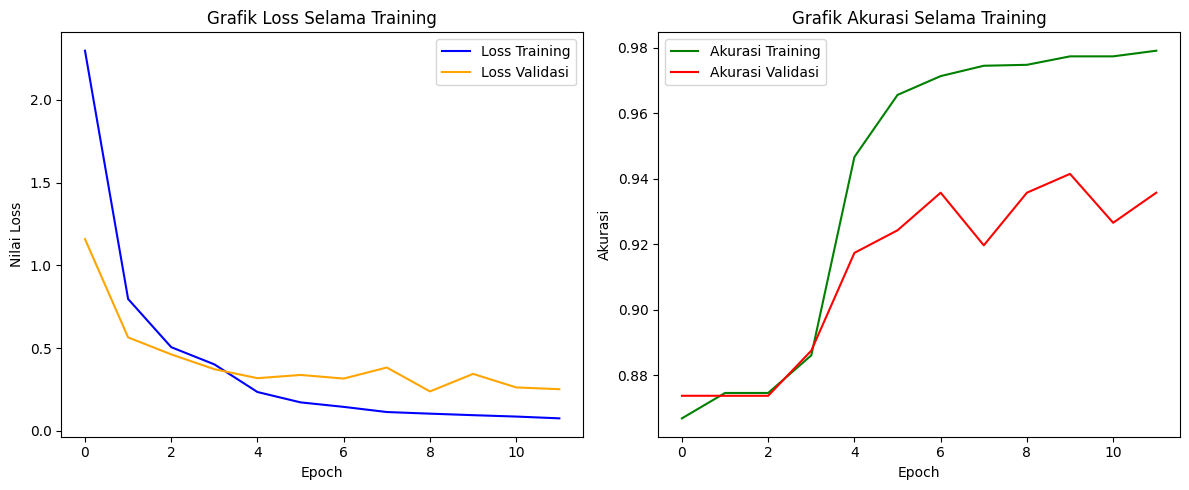

In [ ]:
# === Visualisasi Performa Pelatihan ===
import matplotlib.pyplot as plt # Import the pyplot module from matplotlib

plt.figure(figsize=(12, 5))

# Visualisasi Loss
plt.subplot(1, 2, 1)
plt.plot(training_log.history['loss'], color='blue', label='Loss Training')
plt.plot(training_log.history['val_loss'], color='orange', label='Loss Validasi')
plt.xlabel('Epoch')
plt.ylabel('Nilai Loss')
plt.title('Grafik Loss Selama Training')
plt.legend()

# Visualisasi Akurasi
plt.subplot(1, 2, 2)
plt.plot(training_log.history['accuracy'], color='green', label='Akurasi Training')
plt.plot(training_log.history['val_accuracy'], color='red', label='Akurasi Validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.title('Grafik Akurasi Selama Training')
plt.legend()

plt.tight_layout()
plt.show()

##**Inference atau testing**##

In [ ]:
# Membandingkan performa ketiga model berdasarkan akurasi
skor_akurasi = {
    'SVM': model_svm.score(X_test_vec, y_test),  # Get accuracy directly using .score()
    'Random Forest': akurasi_rf,  # Changed accuracy_rf to akurasi_rf
    'LSTM': final_accuracy  # Use the correct variable for LSTM accuracy
}

# Menentukan model dengan akurasi tertinggi
model_terbaik = max(skor_akurasi, key=skor_akurasi.get)
print(f"\nModel dengan performa terbaik (akurasi tertinggi): {model_terbaik}")


Model dengan performa terbaik (akurasi tertinggi): SVM


In [ ]:
# Membandingkan performa ketiga model berdasarkan akurasi
skor_akurasi = {
    'SVM': model_svm.score(X_test_vec, y_test),  # Get accuracy directly using .score()
    'Random Forest': akurasi_rf,  # Use 'akurasi_rf' instead of 'accuracy_rf'
    'LSTM': final_accuracy  # Use the correct variable for LSTM accuracy
}

# Menentukan model dengan akurasi tertinggi
model_terbaik = max(skor_akurasi, key=skor_akurasi.get)
print(f"\nModel dengan performa terbaik (akurasi tertinggi): {model_terbaik}")

# Assign the name of the best model to best_model_name
best_model_name = model_terbaik

# Latih LabelEncoder pada label asli
label_encoder = LabelEncoder()
label_encoder.fit(df['sentimen'])

# Tentukan model terbaik berdasarkan nama yang telah dipilih
if best_model_name == 'SVM':
    model_terpilih = model_svm # Use the correct model variable
    prediksi_terbaik = model_svm.predict(X_test_vec) # Use predict on correct data
elif best_model_name == 'Random Forest':
    model_terpilih = model_rf # Use the correct model variable
    prediksi_terbaik = model_rf.predict(X_test_vec) # Use predict on correct data
else:
    model_terpilih = lstm_network # Use the actual LSTM model variable
    prediksi_terbaik = lstm_network.predict(X_test_pad).argmax(axis=1)

# Buat DataFrame untuk membandingkan label asli dan hasil prediksi
hasil_klasifikasi = pd.DataFrame({
    'Label Asli': label_encoder.inverse_transform(y_test),
    'Label Prediksi': label_encoder.inverse_transform(prediksi_terbaik)
})

print("\nHasil Perbandingan Label Asli vs Prediksi:")
print(hasil_klasifikasi.head())


Model dengan performa terbaik (akurasi tertinggi): SVM

Hasil Perbandingan Label Asli vs Prediksi:
  Label Asli Label Prediksi
0     netral         netral
1     netral         netral
2    positif        positif
3     netral         netral
4     netral         netral


In [ ]:
!pip freeze > requirements.txt